# CatBoost Model Implementation with Poisson Loss and New Features

This notebook implements a CatBoost Regressor model with Poisson loss for predicting gift selection counts. It builds upon the previous XGBoost work by:
1. Using CatBoost's native handling of categorical features.
2. Employing a Poisson loss function, suitable for count data, removing the need for log transformation of the target.
3. Incorporating new shop-level share, rank, and interaction features as per the ML expert's recommendations and Phase 3.5 plan.

## 1. Setup and Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pickle
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder # Still needed for y_strata, not for X features for CatBoost
from sklearn.feature_extraction import FeatureHasher

import catboost
from catboost import CatBoostRegressor, Pool, metrics, cv

import warnings
warnings.filterwarnings('ignore')

print(f"CatBoost version: {catboost.__version__}")
print("Libraries imported successfully")

CatBoost version: 1.2.8
Libraries imported successfully


## 2. Data Loading and Initial Preprocessing
Reusing the same data loading and cleaning steps from `breakthrough_training.ipynb`.

In [3]:
print("[DATA] Loading historical selection data...")
data_path = "../src/data/historical/present.selection.historic.csv"
raw_data = pd.DataFrame()
try:
    raw_data = pd.read_csv(data_path, encoding='utf-8', dtype='str')
    print(f"Loaded {len(raw_data)} selection events from {data_path}")
    print(f"Columns: {list(raw_data.columns)}")
except FileNotFoundError:
    print(f"ERROR: {data_path} not found.")

if not raw_data.empty:
    print("\n[CLEAN] Cleaning data...")
    cleaned_data = raw_data.copy()
    for col in cleaned_data.columns:
        cleaned_data[col] = cleaned_data[col].astype(str).str.strip('"').str.strip()
    cleaned_data = cleaned_data.fillna("NONE")
    categorical_cols_to_lower = ['employee_gender', 'product_target_gender', 
                       'product_utility_type', 'product_durability', 'product_type']
    for col in categorical_cols_to_lower:
        if col in cleaned_data.columns:
            cleaned_data[col] = cleaned_data[col].str.lower()
    print(f"Data cleaning complete: {len(cleaned_data)} records")
else:
    print("Raw data is empty, skipping cleaning.")
    cleaned_data = pd.DataFrame()

[DATA] Loading historical selection data...
Loaded 178736 selection events from ../src/data/historical/present.selection.historic.csv
Columns: ['employee_shop', 'employee_branch', 'employee_gender', 'product_main_category', 'product_sub_category', 'product_brand', 'product_color', 'product_durability', 'product_target_gender', 'product_utility_type', 'product_type']

[CLEAN] Cleaning data...
Data cleaning complete: 178736 records


## 3. Data Aggregation
Aggregating data to unique product-employee combinations.

In [4]:
agg_data = pd.DataFrame() 
grouping_cols = []
if not cleaned_data.empty:
    grouping_cols = [
        'employee_shop', 'employee_branch', 'employee_gender',
        'product_main_category', 'product_sub_category', 'product_brand',
        'product_color', 'product_durability', 'product_target_gender',
        'product_utility_type', 'product_type'
    ]
    print(f"\n[AGGREGATE] Grouping by {len(grouping_cols)} features: {grouping_cols}")
    agg_data = cleaned_data.groupby(grouping_cols).size().reset_index(name='selection_count')
    if not agg_data.empty:
        compression_ratio = len(cleaned_data) / len(agg_data) if len(agg_data) > 0 else 0
        print(f"Aggregation complete:")
        print(f"  {len(cleaned_data)} events → {len(agg_data)} unique combinations")
        print(f"  Compression ratio: {compression_ratio:.1f}x")
    else:
        print("agg_data is empty after grouping.")
else:
    print("Cleaned data is empty, skipping aggregation.")


[AGGREGATE] Grouping by 11 features: ['employee_shop', 'employee_branch', 'employee_gender', 'product_main_category', 'product_sub_category', 'product_brand', 'product_color', 'product_durability', 'product_target_gender', 'product_utility_type', 'product_type']
Aggregation complete:
  178736 events → 98741 unique combinations
  Compression ratio: 1.8x


## 4. Shop Assortment Feature Engineering (Existing)
Reusing the non-leaky shop assortment features from `breakthrough_training.ipynb`.

In [5]:
agg_data_with_shop_features = pd.DataFrame() 
if not agg_data.empty:
    shop_summary = agg_data.groupby('employee_shop').agg(
        unique_product_combinations_in_shop=('product_main_category', 'count'),
        distinct_main_categories_in_shop=('product_main_category', 'nunique'),
        distinct_sub_categories_in_shop=('product_sub_category', 'nunique'),
        distinct_brands_in_shop=('product_brand', 'nunique'),
        distinct_utility_types_in_shop=('product_utility_type', 'nunique')
    ).reset_index()

    shop_main_cat_counts = agg_data.groupby(['employee_shop', 'product_main_category'])['selection_count'].sum().reset_index()
    idx = shop_main_cat_counts.groupby(['employee_shop'])['selection_count'].transform(max) == shop_main_cat_counts['selection_count']
    shop_top_main_cats = shop_main_cat_counts[idx].drop_duplicates(subset=['employee_shop'], keep='first')
    shop_top_main_cats = shop_top_main_cats[['employee_shop', 'product_main_category']].rename(
        columns={'product_main_category': 'shop_most_frequent_main_category_selected'}
    )

    shop_brand_counts = agg_data.groupby(['employee_shop', 'product_brand'])['selection_count'].sum().reset_index()
    idx_brand = shop_brand_counts.groupby(['employee_shop'])['selection_count'].transform(max) == shop_brand_counts['selection_count']
    shop_top_brands = shop_brand_counts[idx_brand].drop_duplicates(subset=['employee_shop'], keep='first')
    shop_top_brands = shop_top_brands[['employee_shop', 'product_brand']].rename(
        columns={'product_brand': 'shop_most_frequent_brand_selected'}
    )

    shop_features_df = shop_summary.copy()
    if not shop_top_main_cats.empty:
        shop_features_df = pd.merge(shop_features_df, shop_top_main_cats, on='employee_shop', how='left')
    if not shop_top_brands.empty:
        shop_features_df = pd.merge(shop_features_df, shop_top_brands, on='employee_shop', how='left')
    
    shop_features_df = shop_features_df.rename(columns={
        'distinct_main_categories_in_shop': 'shop_main_category_diversity_selected',
        'distinct_brands_in_shop': 'shop_brand_diversity_selected',
        'distinct_utility_types_in_shop': 'shop_utility_type_diversity_selected',
        'distinct_sub_categories_in_shop': 'shop_sub_category_diversity_selected'
    })
    
    agg_data_with_shop_features = pd.merge(agg_data, shop_features_df, on='employee_shop', how='left')
    
    # Ensure 'unique_product_combinations_in_shop' is numeric after merge, fill NaNs with 0
    if 'unique_product_combinations_in_shop' in agg_data_with_shop_features.columns:
        agg_data_with_shop_features['unique_product_combinations_in_shop'] = pd.to_numeric(agg_data_with_shop_features['unique_product_combinations_in_shop'], errors='coerce').fillna(0)

    # Product-Relative-to-Shop Features
    df_temp = agg_data_with_shop_features.copy()
    if 'shop_most_frequent_main_category_selected' in df_temp.columns:
        df_temp['is_shop_most_frequent_main_category'] = (
            df_temp['product_main_category'] == df_temp['shop_most_frequent_main_category_selected']
        ).astype(int)
    else:
        df_temp['is_shop_most_frequent_main_category'] = 0

    if 'shop_most_frequent_brand_selected' in df_temp.columns:
        df_temp['is_shop_most_frequent_brand'] = (
            df_temp['product_brand'] == df_temp['shop_most_frequent_brand_selected']
        ).astype(int)
    else:
        df_temp['is_shop_most_frequent_brand'] = 0
    agg_data_with_shop_features = df_temp
    print(f"Shape after existing shop features: {agg_data_with_shop_features.shape}")
else:
    print("Skipping existing shop features as agg_data is empty.")
    agg_data_with_shop_features = agg_data.copy()

Shape after existing shop features: (98741, 21)


## 5. New Feature Engineering (Share, Rank, Interactions)
Implementing new features as per Phase 3.5 plan.

In [6]:
final_features_df = pd.DataFrame()
if not agg_data_with_shop_features.empty:
    df = agg_data_with_shop_features.copy()
    print(f"Starting new feature engineering (interaction features only). Initial shape: {df.shape}")

    # C. Interaction features via hashing
    hasher = FeatureHasher(n_features=10, input_type='string') 
    interaction_strings = df.apply(
        lambda x: f"{x['employee_branch']}_{x['product_main_category']}", axis=1
    )
    interaction_hashed_features = hasher.transform(interaction_strings.astype(str).apply(lambda s: [s])).toarray()
    for i in range(interaction_hashed_features.shape[1]):
        df[f'interaction_hash_{i}'] = interaction_hashed_features[:, i]
    
    final_features_df = df
    print(f"Shape after new feature engineering (interaction features only): {final_features_df.shape}")
else:
    print("Skipping new feature engineering as input df is empty.")
    final_features_df = agg_data_with_shop_features.copy()


Starting new feature engineering (interaction features only). Initial shape: (98741, 21)
Shape after new feature engineering (interaction features only): (98741, 31)


## 6. Final Feature Preparation for CatBoost Model

In [7]:
X = pd.DataFrame()
y = pd.Series(dtype='float64')
y_strata = pd.Series(dtype='float64') # For stratified splitting

categorical_features_names = [] # To store names of categorical columns for CatBoost

if not final_features_df.empty and 'selection_count' in final_features_df.columns:
    print("[FEATURES PREP] Preparing final X, y for CatBoost...")
    # Ensure grouping_cols is defined in this cell's scope
    if 'grouping_cols' not in globals() and 'grouping_cols' not in locals():
        print("DEBUG: grouping_cols not in scope, attempting to redefine from common knowledge or previous cells.")
        grouping_cols = [
            'employee_shop', 'employee_branch', 'employee_gender',
            'product_main_category', 'product_sub_category', 'product_brand',
            'product_color', 'product_durability', 'product_target_gender',
            'product_utility_type', 'product_type'
        ]
    y = pd.to_numeric(final_features_df['selection_count'], errors='coerce').fillna(0) # Target is raw counts
    X = final_features_df.drop(columns=['selection_count']).copy()

    # Define categorical features for CatBoost
    categorical_features_names = list(grouping_cols) 
    categorical_features_names.extend([
        'shop_most_frequent_main_category_selected',
        'shop_most_frequent_brand_selected',
        'shop_main_category_diversity_selected',
        'shop_brand_diversity_selected',
        'shop_utility_type_diversity_selected',
        'shop_sub_category_diversity_selected'
        # 'is_shop_most_frequent_main_category', # Kept as numeric (0/1)
        # 'is_shop_most_frequent_brand'  # Kept as numeric (0/1)
    ])

    valid_categorical_features = []
    for col in categorical_features_names:
        if col in X.columns:
            X[col] = X[col].astype(str)
            valid_categorical_features.append(col)
        else:
            print(f"Warning: Categorical feature '{col}' intended for CatBoost not found in X.")
    categorical_features_names = valid_categorical_features

    # Handle potential NaNs and ensure correct types for remaining columns
    for col in X.columns:
        if col not in categorical_features_names:
            if X[col].dtype == 'object':
                X[col] = pd.to_numeric(X[col], errors='coerce')
            
            if pd.api.types.is_numeric_dtype(X[col]):
                 if X[col].isnull().any():
                    X[col] = X[col].fillna(X[col].median())
            else:
                print(f"Warning: Column '{col}' could not be made numeric and is not categorical. Dropping.")
                X = X.drop(columns=[col])
        elif X[col].isnull().any():
             pass # CatBoost handles string 'nan' in categorical features that were converted to str

    y_strata = pd.cut(y, bins=[-1, 0, 1, 2, 5, 10, np.inf], labels=[0, 1, 2, 3, 4, 5], include_lowest=True)

    print(f"\nFinal X features shape: {X.shape}")
    print(f"Target y shape: {y.shape}")
    print(f"Categorical features for CatBoost ({len(categorical_features_names)}): {categorical_features_names}")
    if not y_strata.empty:
      print(f"Stratification distribution:\n{y_strata.value_counts().sort_index().to_dict()}")
else:
    print("Skipping final feature preparation as final_features_df is empty or 'selection_count' is missing.")

[FEATURES PREP] Preparing final X, y for CatBoost...

Final X features shape: (98741, 30)
Target y shape: (98741,)
Categorical features for CatBoost (17): ['employee_shop', 'employee_branch', 'employee_gender', 'product_main_category', 'product_sub_category', 'product_brand', 'product_color', 'product_durability', 'product_target_gender', 'product_utility_type', 'product_type', 'shop_most_frequent_main_category_selected', 'shop_most_frequent_brand_selected', 'shop_main_category_diversity_selected', 'shop_brand_diversity_selected', 'shop_utility_type_diversity_selected', 'shop_sub_category_diversity_selected']
Stratification distribution:
{0: 0, 1: 66659, 2: 17205, 3: 11274, 4: 2636, 5: 967}


## 7. CatBoost Model Training (Single-Stage with Poisson Loss)

In [8]:
trained_catboost_model = None
r2_val_catboost = 0.0

if not X.empty and not y.empty and not y_strata.empty:
    print("\n[MODEL TRAINING] Training CatBoost Regressor with Poisson Loss...")
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_strata
    )
    
    print(f"Train set size: {X_train.shape}, {y_train.shape}")
    print(f"Validation set size: {X_val.shape}, {y_val.shape}")

    # Initialize CatBoost Regressor
    catboost_model = CatBoostRegressor(
        iterations=1000,
        loss_function='Poisson',  # Key change: Poisson loss for count data
        eval_metric='R2',        # Evaluate with R2 directly on counts
        cat_features=categorical_features_names, # Pass names of categorical features
        random_seed=42,
        learning_rate=0.05, # Typical starting point
        depth=6,            # Typical starting point
        l2_leaf_reg=3,      # Regularization
        early_stopping_rounds=50,
        verbose=100 # Print progress every 100 iterations
    )

    # Train the model
    catboost_model.fit(
        X_train, y_train, 
        eval_set=(X_val, y_val),
        # cat_features parameter is set in constructor, no need here if X dtypes are correct
    )
    
    trained_catboost_model = catboost_model
    
    # Evaluate on validation set
    y_pred_val = trained_catboost_model.predict(X_val)
    y_pred_val = np.maximum(0, y_pred_val) # Ensure predictions are non-negative for count data
    
    r2_val_catboost = r2_score(y_val, y_pred_val)
    mae_val_catboost = mean_absolute_error(y_val, y_pred_val)
    rmse_val_catboost = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    print(f"\nCatBoost Validation R² (original scale): {r2_val_catboost:.4f}")
    print(f"CatBoost Validation MAE (original scale): {mae_val_catboost:.4f}")
    print(f"CatBoost Validation RMSE (original scale): {rmse_val_catboost:.4f}")

    # Cross-validation (optional, can be time-consuming)
    # print("\nPerforming CatBoost CV...")
    # cv_params = catboost_model.get_params()
    # cv_data = cv(
    #     Pool(X, y, cat_features=categorical_features_names),
    #     cv_params,
    #     fold_count=5,
    #     verbose=False
    # )
    # print(f"CatBoost CV R2 mean: {cv_data['test-R2-mean'].iloc[-1]:.4f}")

else:
    print("Skipping CatBoost Model Training as X, y or y_strata is empty/invalid.")


[MODEL TRAINING] Training CatBoost Regressor with Poisson Loss...
Train set size: (78992, 30), (78992,)
Validation set size: (19749, 30), (19749,)
0:	learn: -0.4781045	test: -0.5322275	best: -0.5322275 (0)	total: 367ms	remaining: 6m 6s
100:	learn: -0.1191520	test: -0.1387951	best: -0.1387951 (100)	total: 20.9s	remaining: 3m 6s
200:	learn: -0.1089287	test: -0.1305875	best: -0.1305875 (200)	total: 39.8s	remaining: 2m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = -0.1294268421
bestIteration = 237

Shrink model to first 238 iterations.

CatBoost Validation R² (original scale): 0.5920
CatBoost Validation MAE (original scale): 0.7348
CatBoost Validation RMSE (original scale): 1.5495


In [10]:
import optuna

# Ensure X_train, y_train, X_val, y_val, and categorical_features_names 
# are available from the previous cell's execution context.

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 400, 1500, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 20.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'loss_function': 'Poisson',
        'eval_metric': 'R2',
        'random_seed': 42,
        'verbose': 0, 
        'early_stopping_rounds': 50
    }

    model = CatBoostRegressor(**param, cat_features=categorical_features_names)
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=param.get('early_stopping_rounds', 50), verbose=0)
    
    preds = model.predict(X_val)
    preds = np.maximum(0, preds)
    r2 = r2_score(y_val, preds)
    
    return r2

print("\\n[HYPERPARAMETER TUNING] Starting Optuna optimization...")
if 'X_train' in globals() and 'y_train' in globals() and 'X_val' in globals() and 'y_val' in globals():
    study = optuna.create_study(direction='maximize', study_name='catboost_poisson_r2_nonleaky')
    # For a more thorough search, increase n_trials (e.g., to 30-50 or more)
    # Using 15 trials for now to balance speed and exploration.
    study.optimize(objective, n_trials=15) 

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    best_trial = study.best_trial

    print(f"  Value (R2): {best_trial.value:.4f}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    print("\\nRetraining model with best Optuna hyperparameters...")
    best_params_from_optuna = best_trial.params.copy()
    best_params_from_optuna['loss_function'] = 'Poisson'
    best_params_from_optuna['eval_metric'] = 'R2'
    best_params_from_optuna['random_seed'] = 42
    best_params_from_optuna['verbose'] = 100 
    
    if 'early_stopping_rounds' not in best_params_from_optuna:
        best_params_from_optuna['early_stopping_rounds'] = 50 
    
    trained_catboost_model_optuna = CatBoostRegressor(**best_params_from_optuna, cat_features=categorical_features_names)
    
    trained_catboost_model_optuna.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                                 early_stopping_rounds=best_params_from_optuna.get('early_stopping_rounds', 50), 
                                 verbose=best_params_from_optuna.get('verbose',100))
    
    y_pred_val_optuna = trained_catboost_model_optuna.predict(X_val)
    y_pred_val_optuna = np.maximum(0, y_pred_val_optuna)
    
    r2_val_optuna = r2_score(y_val, y_pred_val_optuna)
    mae_val_optuna = mean_absolute_error(y_val, y_pred_val_optuna)
    rmse_val_optuna = np.sqrt(mean_squared_error(y_val, y_pred_val_optuna))

    print(f"\\nOptimized CatBoost Validation R² (original scale): {r2_val_optuna:.4f}")
    print(f"Optimized CatBoost Validation MAE (original scale): {mae_val_optuna:.4f}")
    print(f"Optimized CatBoost Validation RMSE (original scale): {rmse_val_optuna:.4f}")
    
    # Update the main trained_model to the optimized one so subsequent cells (like feature importance) use it
    trained_catboost_model = trained_catboost_model_optuna
else:
    print("Skipping Optuna tuning as training data (X_train etc.) is not available.")



[I 2025-06-16 09:17:30,661] A new study created in memory with name: catboost_poisson_r2_nonleaky


\n[HYPERPARAMETER TUNING] Starting Optuna optimization...


[I 2025-06-16 09:22:01,650] Trial 0 finished with value: 0.6435019357475302 and parameters: {'iterations': 700, 'learning_rate': 0.012912002158777447, 'depth': 10, 'l2_leaf_reg': 2.027557341274432, 'border_count': 49, 'random_strength': 0.036795993528299695, 'bagging_temperature': 0.40201211320800834}. Best is trial 0 with value: 0.6435019357475302.
[I 2025-06-16 09:23:28,685] Trial 1 finished with value: 0.5680981878671671 and parameters: {'iterations': 500, 'learning_rate': 0.028548056642274344, 'depth': 5, 'l2_leaf_reg': 6.590974591243279, 'border_count': 150, 'random_strength': 2.2777328861985528e-05, 'bagging_temperature': 0.8185734466392435}. Best is trial 0 with value: 0.6435019357475302.
[I 2025-06-16 09:25:01,999] Trial 2 finished with value: 0.5970020657910144 and parameters: {'iterations': 1400, 'learning_rate': 0.03314514383137139, 'depth': 8, 'l2_leaf_reg': 0.0509215822311017, 'border_count': 85, 'random_strength': 8.389280739088139e-06, 'bagging_temperature': 0.0453898663

Number of finished trials:  15
Best trial:
  Value (R2): 0.6435
  Params: 
    iterations: 700
    learning_rate: 0.012912002158777447
    depth: 10
    l2_leaf_reg: 2.027557341274432
    border_count: 49
    random_strength: 0.036795993528299695
    bagging_temperature: 0.40201211320800834
\nRetraining model with best Optuna hyperparameters...
0:	learn: -0.4916124	test: -0.5473600	best: -0.5473600 (0)	total: 521ms	remaining: 6m 4s
100:	learn: -0.2126176	test: -0.2440456	best: -0.2440456 (100)	total: 48.6s	remaining: 4m 48s
200:	learn: -0.1368768	test: -0.1643582	best: -0.1643582 (200)	total: 1m 40s	remaining: 4m 9s
300:	learn: -0.1122992	test: -0.1409060	best: -0.1409060 (300)	total: 2m 31s	remaining: 3m 20s
400:	learn: -0.1027722	test: -0.1329915	best: -0.1329915 (400)	total: 3m 21s	remaining: 2m 30s
500:	learn: -0.0981713	test: -0.1296550	best: -0.1296550 (500)	total: 4m 11s	remaining: 1m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = -0.1294638233
bestIterati

## Cross Validation

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
import numpy as np

print("\\n[CROSS-VALIDATION] Performing Stratified K-Fold CV with optimized parameters...")

# Ensure X, y, categorical_features_names, and best_params_from_optuna are available
if 'X' in globals() and 'y' in globals() and 'categorical_features_names' in globals() and 'best_params_from_optuna' in globals():
    n_splits = 5 # Or another appropriate number like 3 or 10
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Need y_strata for splitting, ensure it's available from Cell 6 or recalculate
    if 'y_strata' not in globals() or len(y_strata) != len(y):
        print("Recalculating y_strata for CV...")
        y_strata = pd.cut(y, bins=[-1, 0, 1, 2, 5, 10, np.inf], labels=[0, 1, 2, 3, 4, 5], include_lowest=True)

    fold_r2_scores = []
    
    # Ensure y_strata has no NaNs for splitting, and X, y are aligned with it
    valid_cv_indices = y_strata.dropna().index
    X_for_cv = X.loc[valid_cv_indices]
    y_for_cv = y.loc[valid_cv_indices]
    y_strata_for_cv = y_strata.loc[valid_cv_indices]

    if len(X_for_cv) > 0 and len(y_strata_for_cv) == len(X_for_cv):
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_for_cv, y_strata_for_cv)):
            print(f"  Training fold {fold+1}/{n_splits}...")
            X_train_fold, X_val_fold = X_for_cv.iloc[train_idx], X_for_cv.iloc[val_idx]
            y_train_fold, y_val_fold = y_for_cv.iloc[train_idx], y_for_cv.iloc[val_idx]
            
            # Re-initialize model with best params for each fold
            cv_model = CatBoostRegressor(**best_params_from_optuna, cat_features=categorical_features_names)
            
            cv_model.fit(X_train_fold, y_train_fold, 
                         eval_set=[(X_val_fold, y_val_fold)], # Optional: for monitoring, but early stopping is based on iterations here
                         early_stopping_rounds=best_params_from_optuna.get('early_stopping_rounds', 50), # Use from Optuna
                         verbose=0) # Suppress output during CV folds
            
            y_pred_fold = cv_model.predict(X_val_fold)
            y_pred_fold = np.maximum(0, y_pred_fold)
            fold_r2 = r2_score(y_val_fold, y_pred_fold)
            fold_r2_scores.append(fold_r2)
            print(f"    Fold {fold+1} R²: {fold_r2:.4f}")
        
        print(f"\nOptimized CatBoost Stratified K-Fold CV R² (mean): {np.mean(fold_r2_scores):.4f}")
        print(f"Optimized CatBoost Stratified K-Fold CV R² (std): {np.std(fold_r2_scores):.4f}")
    else:
        print("Skipping CV: Not enough valid data after handling NaNs in strata or strata mismatch.")
else:
    print("Skipping Cross-Validation as necessary variables (X, y, best_params_from_optuna, etc.) are not available.")



\n[CROSS-VALIDATION] Performing Stratified K-Fold CV with optimized parameters...
  Training fold 1/5...
    Fold 1 R²: 0.5023
  Training fold 2/5...
    Fold 2 R²: 0.6124
  Training fold 3/5...
    Fold 3 R²: 0.5817
  Training fold 4/5...
    Fold 4 R²: 0.6083
  Training fold 5/5...
    Fold 5 R²: 0.6422

Optimized CatBoost Stratified K-Fold CV R² (mean): 0.5894
Optimized CatBoost Stratified K-Fold CV R² (std): 0.0476


## 8. Feature Importance (CatBoost)


[ANALYSIS] CatBoost Feature Importance Analysis

CatBoost Feature Importance Ranking:
                                      feature  importance
1                             employee_branch   24.490174
2                             employee_gender   16.288557
0                               employee_shop   10.958714
4                        product_sub_category   10.547405
17          shop_most_frequent_brand_selected    7.691320
5                               product_brand    7.456126
13       shop_sub_category_diversity_selected    6.804436
14              shop_brand_diversity_selected    4.518791
6                               product_color    2.839921
3                       product_main_category    1.822018
12      shop_main_category_diversity_selected    1.792272
16  shop_most_frequent_main_category_selected    1.320527
11        unique_product_combinations_in_shop    1.240075
19                is_shop_most_frequent_brand    0.789295
22                         interaction_hash

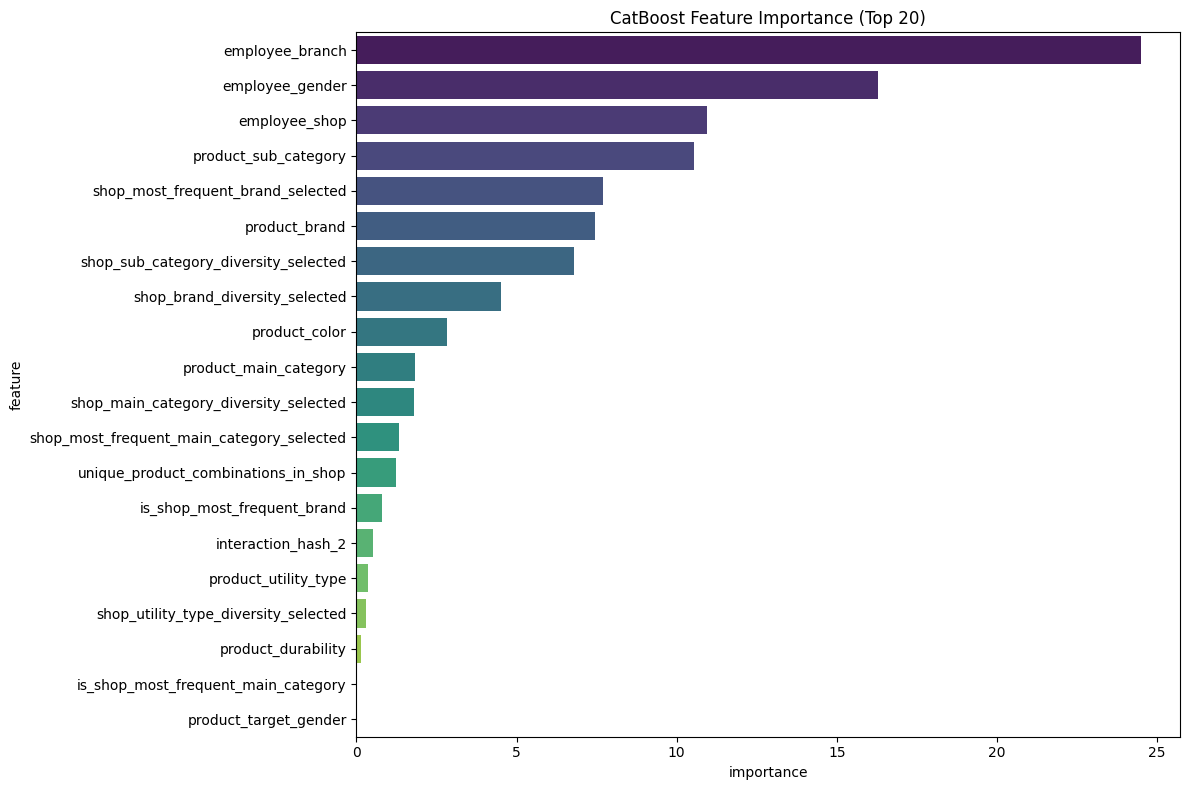

In [13]:
if trained_catboost_model is not None and not X.empty:
    print("\n[ANALYSIS] CatBoost Feature Importance Analysis")
    feature_importances = trained_catboost_model.get_feature_importance()
    feature_names = X.columns
    
    importance_df_catboost = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)
    
    print("\nCatBoost Feature Importance Ranking:")
    # for i, row in importance_df_catboost.head(20).iterrows(): # Display top 20
    #     print(f"  {row['feature']:<45} {row['importance']:.4f}")
    print(importance_df_catboost.head(20).to_string())

    plt.figure(figsize=(12, max(8, len(importance_df_catboost.head(20)) * 0.3)))
    sns.barplot(x='importance', y='feature', data=importance_df_catboost.head(20), palette='viridis')
    plt.title('CatBoost Feature Importance (Top 20)')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping CatBoost feature importance as model was not trained or X is empty.")

## 9. Summary and Next Steps

This notebook sets up the single-stage CatBoost model. The next steps involve:
1. Fine-tuning hyperparameters for CatBoost.
2. Rigorous cross-validation.
3. Implementing the Two-Stage CatBoost model.
4. Comparing performance against the XGBoost baseline and this single-stage CatBoost model.